In [ ]:
import keras
import itertools as it
import matplotlib.pyplot as pl
from tempfile import TemporaryDirectory

TMPDIR = TemporaryDirectory()
keras.backend.set_image_data_format('channels_first')

# Preprocessing

In [2]:
import os 
from skimage import io
from skimage.color import rgb2gray
from skimage import transform
from math import ceil


IMGSIZE = (100, 100)

def load_images(folder, scalefactor=(2, 2), labeldict=None):
    images = []
    labels = []
    files = os.listdir(folder)
    
    for file in (fname for fname in files if fname.endswith('.png')):
        
        img = io.imread(folder + file).astype(float)
        img = rgb2gray(img)
        # Crop since some of the real world pictures are other shape
        img = img[:IMGSIZE[0], :IMGSIZE[1]]
        # Possibly downscale to speed up processing
        img = transform.downscale_local_mean(img, scalefactor)
        # normalize image range
        img -= np.min(img)
        img /= np.max(img)
        images.append(img)
            
        if labeldict is not None:
            # lookup label for real world data in dict generated from labels.txt
            key, _ = os.path.splitext(file)
            labels.append(labeldict[key])
        else:
            # infere label from filename
            if file.find("einstein") > -1 or file.find("curie") > -1:
                labels.append(1)
            else:
                labels.append(0)
                
    return np.asarray(images)[:, None], np.asarray(labels)

x_train, y_train = load_images('data/aps/train/')
# Artifically pad Einstein's and Curie't to have balanced training set
# ok, since we use data augmentation later anyway
sel = y_train == 1
repeats = len(sel) // sum(sel) - 1
x_train = np.concatenate((x_train[~sel], np.repeat(x_train[sel], repeats, axis=0)),
                         axis=0)
y_train = np.concatenate((y_train[~sel], np.repeat(y_train[sel], repeats, axis=0)),
                         axis=0)

x_test, y_test = load_images('data/aps/test/')

rw_labels = {str(key): 0 if label == 0 else 1
             for key, label in np.loadtxt('data/aps/real_world/labels.txt', dtype=int)}
x_rw, y_rw = load_images('data/aps/real_world/', labeldict=rw_labels)

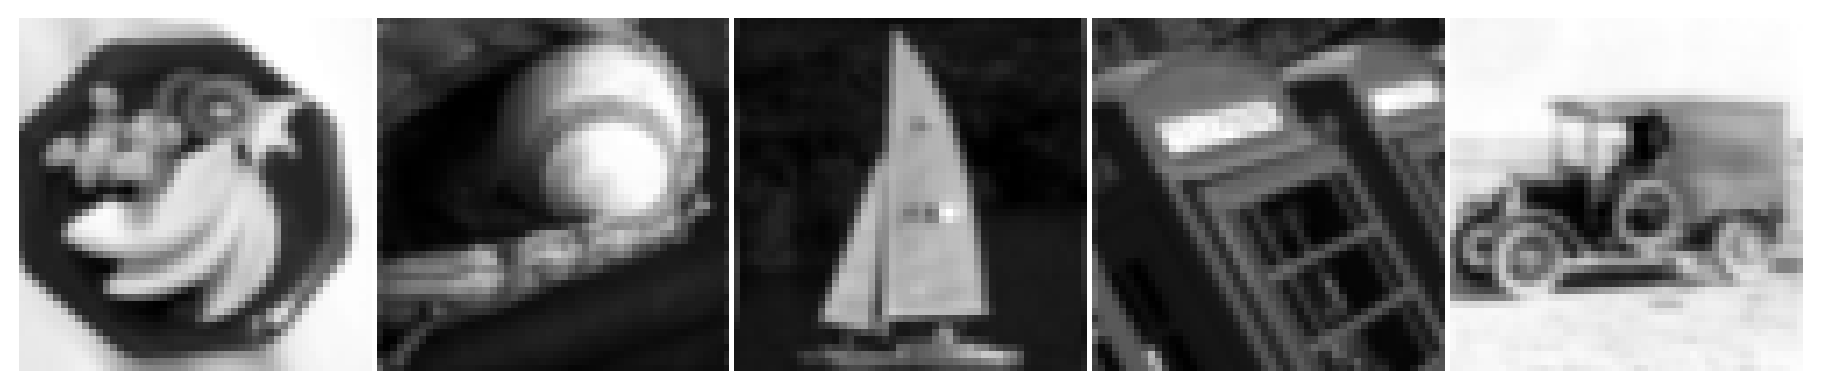

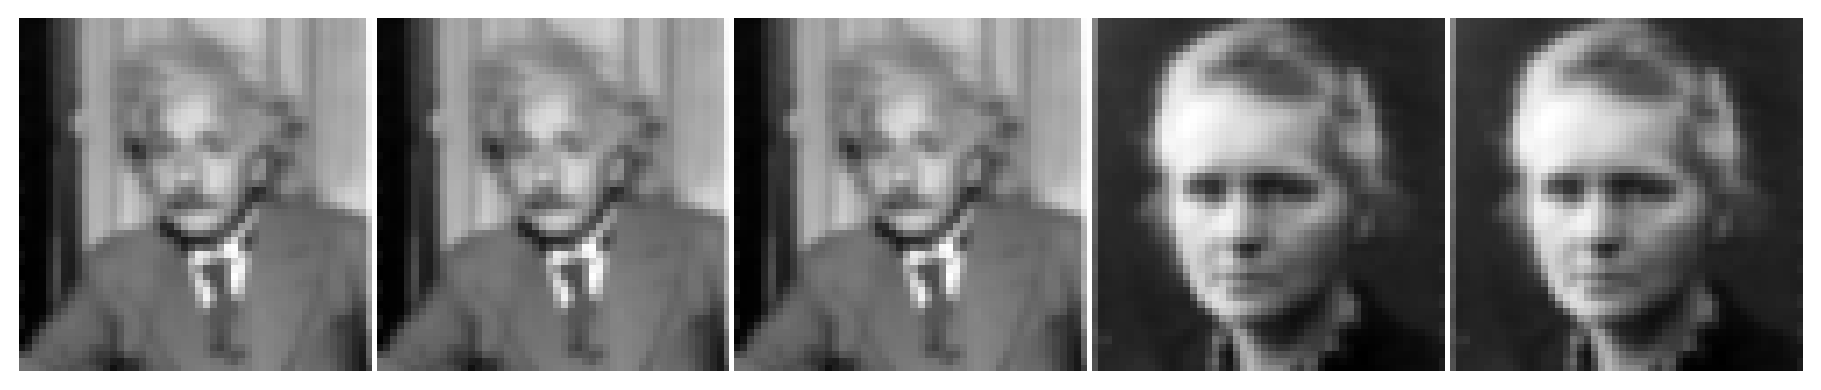

In [3]:
from mpl_toolkits.axes_grid import ImageGrid
from math import ceil

def imsshow(images, grid=(5, -1)):
    assert any(g > 0 for g in grid)
    
    grid_x = grid[0] if grid[0] > 0 else ceil(len(images) / grid[1])
    grid_y = grid[1] if grid[1] > 0 else ceil(len(images) / grid[0])
    
    axes = ImageGrid(pl.gcf(), "111", (grid_y, grid_x), share_all=True)
    for ax, img in zip(axes, images):
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(img[0], cmap='gray')
     
pl.figure(0, figsize=(16, 10))
imsshow(x_train, grid=(5, 1))
pl.show()

pl.figure(0, figsize=(16, 10))
imsshow(x_train[::-4], grid=(5, 1))
pl.show()

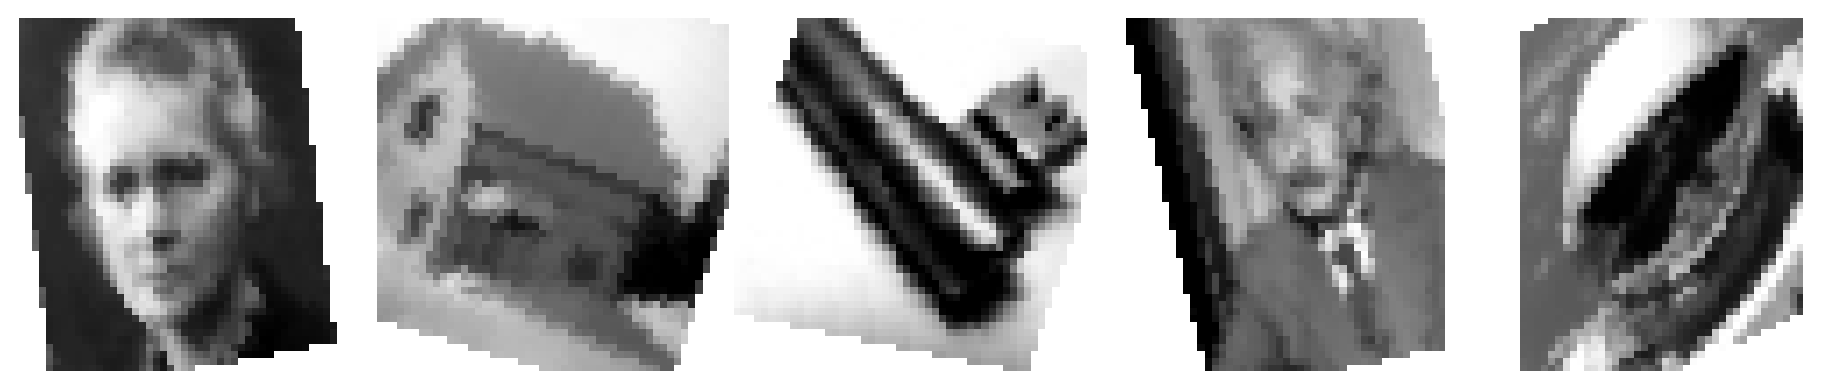

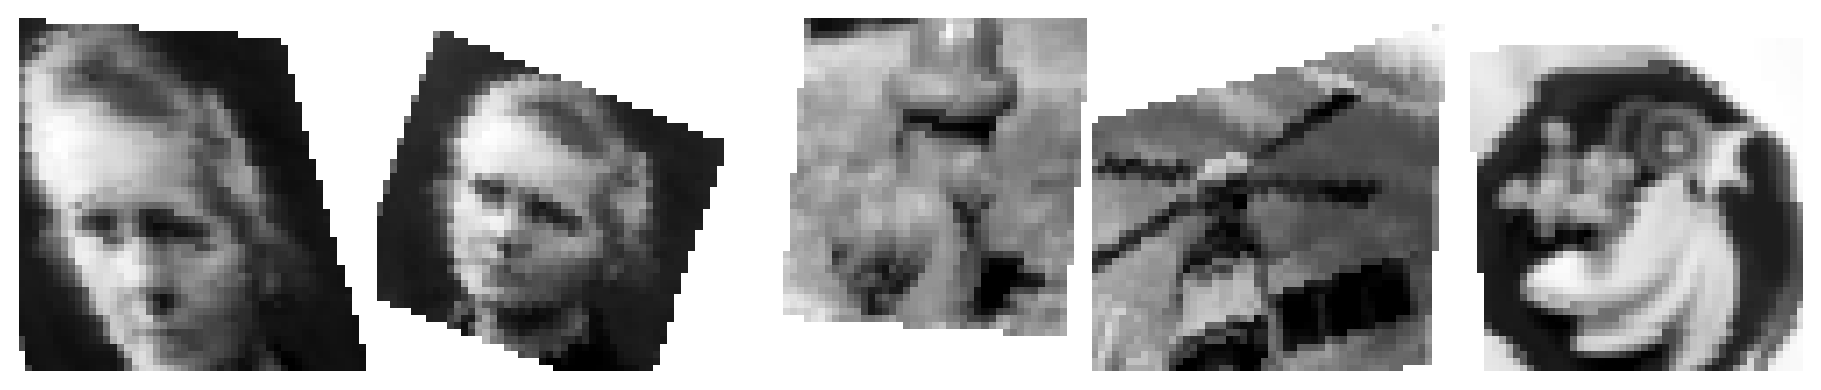

In [4]:
from keras.preprocessing.image import ImageDataGenerator

imggen = ImageDataGenerator(rotation_range=20, 
                            width_shift_range=0.15,
                            height_shift_range=0.15,
                            shear_range=0.4,
                            fill_mode='constant',
                            cval=1.,
                            zoom_range=0.3,
                            channel_shift_range=0.1)
imggen.fit(x_train)

for batch in it.islice(imggen.flow(x_train, batch_size=5), 2):
    pl.figure(0, figsize=(16, 5))
    imsshow(batch, grid=(5, 1))
    pl.show()

# Training LeNet

First, we will train a simple CNN with a single hidden fully connected layer as a classifier.

In [5]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.backend import image_data_format


def generate(figsize, nr_classes, cunits=[20, 50], fcunits=[500]):
    model = Sequential()
    cunits = list(cunits)
    input_shape = figsize + (1,) if image_data_format == 'channels_last' \
        else (1,) + figsize

    model.add(Conv2D(cunits[0], (5, 5), padding='same',
                     activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Convolutional layers
    for nr_units in cunits[1:]:
        model.add(Conv2D(nr_units, (5, 5), padding='same',
                         activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    for nr_units in fcunits:
        model.add(Dense(nr_units, activation='relu'))

    # Output layer
    activation = 'softmax' if nr_classes > 1 else 'sigmoid'
    model.add(Dense(nr_classes, activation=activation))

    return model

In [7]:
from keras.optimizers import Adam
from keras.models import load_model

try:
    model = load_model('aps_lenet.h5')
    print("Model succesfully loaded...")
except OSError:
    print("Saved model not found, traing...")
    model = generate(figsize=x_train.shape[-2:], nr_classes=1,
                     cunits=[24, 48], fcunits=[100])
    optimizer = Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])

    model.fit_generator(imggen.flow(x_train, y_train, batch_size=len(x_train)), 
                        validation_data=imggen.flow(x_test, y_test),
                        steps_per_epoch=100,  epochs=5,
                        verbose=1, validation_steps=256)
    model.save('aps_lenet.h5')

Saved model not found, traing...
Epoch 1/5
100/100 [==============================] - 92s - loss: 0.2592 - acc: 0.8818 - val_loss: 0.0899 - val_acc: 0.9687

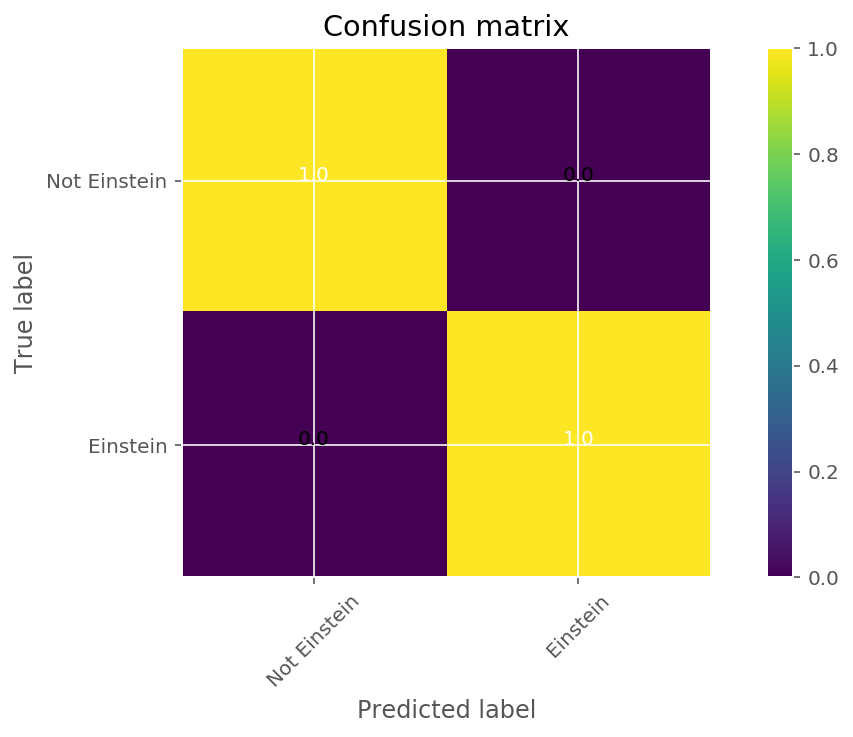

In [10]:
from sklearn.metrics import confusion_matrix

def plot_cm(cm, classes, normalize=False, 
            title='Confusion matrix', cmap=pl.cm.viridis):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()
    tick_marks = np.arange(len(classes))
    pl.xticks(tick_marks, classes, rotation=45)
    pl.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in it.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label')

y_pred_rw = model.predict_classes(x_rw, verbose=0).ravel()
plot_cm(confusion_matrix(y_rw, y_pred_rw), normalize=True,
        classes=["Not Einstein", "Einstein"])

# Training Random Forests

Preprocessing to a fixed size training set since sklearn doesn't suppport streaming training sets?

In [11]:
# Same size training set as LeNet
TRAININGSET_SIZE = len(x_train) * 5 * 100

batch_size = len(x_train)
nr_batches = TRAININGSET_SIZE // batch_size + 1
imgit = imggen.flow(x_train, y=y_train, batch_size=batch_size)
x_train_sampled = np.empty((TRAININGSET_SIZE, 1,) + x_train.shape[-2:])
y_train_sampled = np.empty(TRAININGSET_SIZE)

for batch, (x_batch, y_batch) in enumerate(it.islice(imgit, nr_batches)):
    buflen = len(x_train_sampled[batch * batch_size:(batch + 1) * batch_size])
    x_train_sampled[batch * batch_size:(batch + 1) * batch_size] = x_batch[:buflen]
    y_train_sampled[batch * batch_size:(batch + 1) * batch_size] = y_batch[:buflen]

In [12]:
from sklearn.ensemble import RandomForestClassifier

rfe = RandomForestClassifier(n_estimators=64, criterion='entropy', n_jobs=-1,
                             verbose=True)
rfe = rfe.fit(x_train_sampled.reshape((TRAININGSET_SIZE, -1)), y_train_sampled)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   42.6s finished


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:    0.0s finished


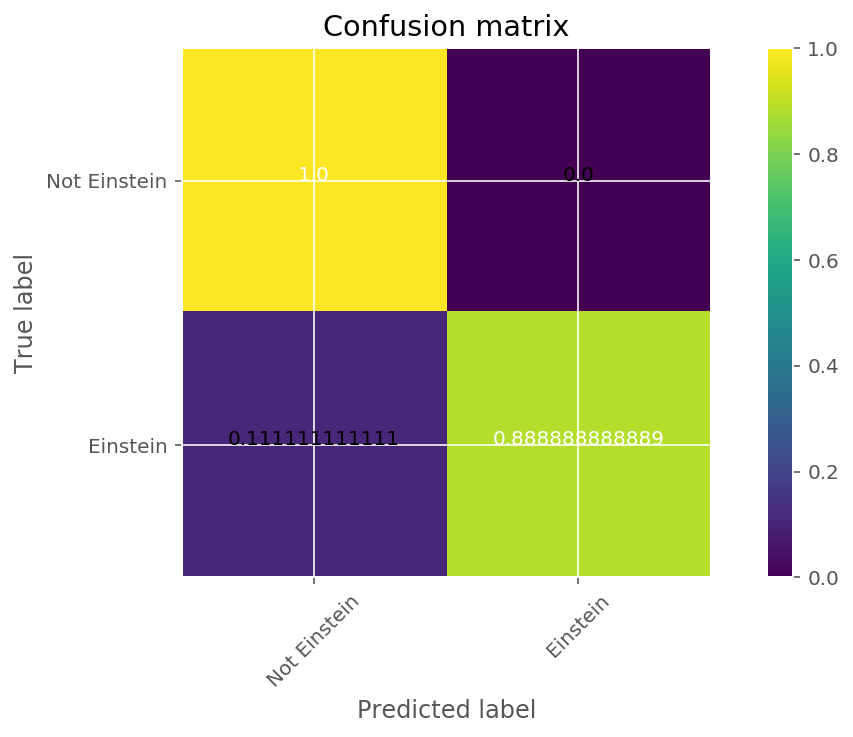

Rightly classified Einsteins:


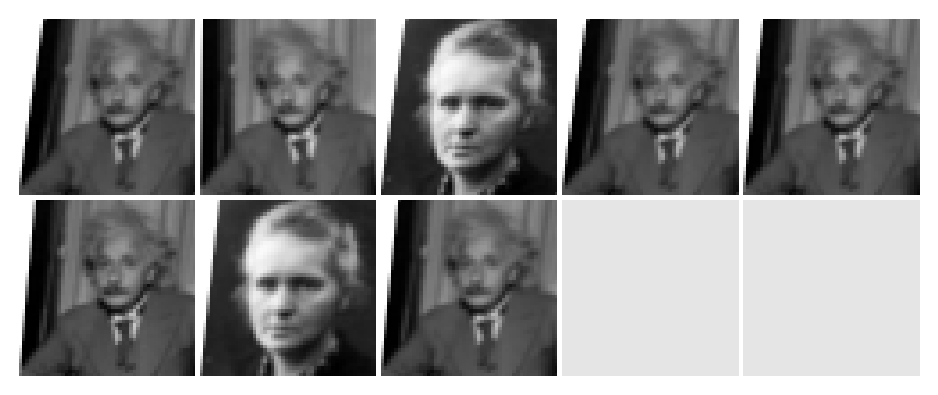

Wrongly classified images:


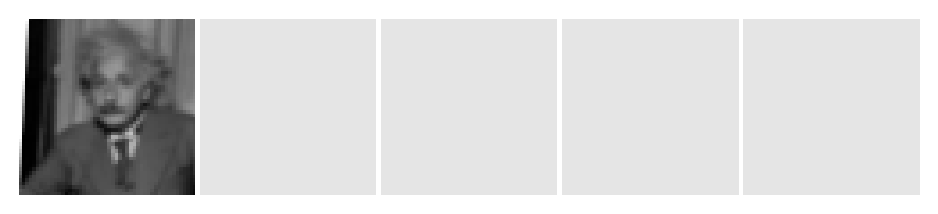

In [13]:
y_pred_rw = rfe.predict(x_rw.reshape((len(x_rw), -1)))
plot_cm(confusion_matrix(y_rw, y_pred_rw), normalize=True,
        classes=["Not Einstein", "Einstein"])
pl.show()

print("Rightly classified Einsteins:")
imsshow(x_rw[((y_rw - y_pred_rw) == 0) * (y_rw == 1)])
pl.show()

print("Wrongly classified images:")
imsshow(x_rw[(y_rw - y_pred_rw) != 0])
pl.show()

So training on raw pixel values might not be a good idea. Let's build a feature extractor based on the trained LeNet (or any other pretrained image classifier)

In [14]:
model = load_model('aps_lenet.h5')
enc_layers = it.takewhile(lambda l: not isinstance(l, keras.layers.Flatten), 
                          model.layers)
encoder_model = keras.models.Sequential(enc_layers)
encoder_model.add(keras.layers.Flatten())
x_train_sampled_enc = encoder_model.predict(x_train_sampled, verbose=True)

22496/22500 [============================>.] - ETA: 0s  

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   16.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:    0.0s finished


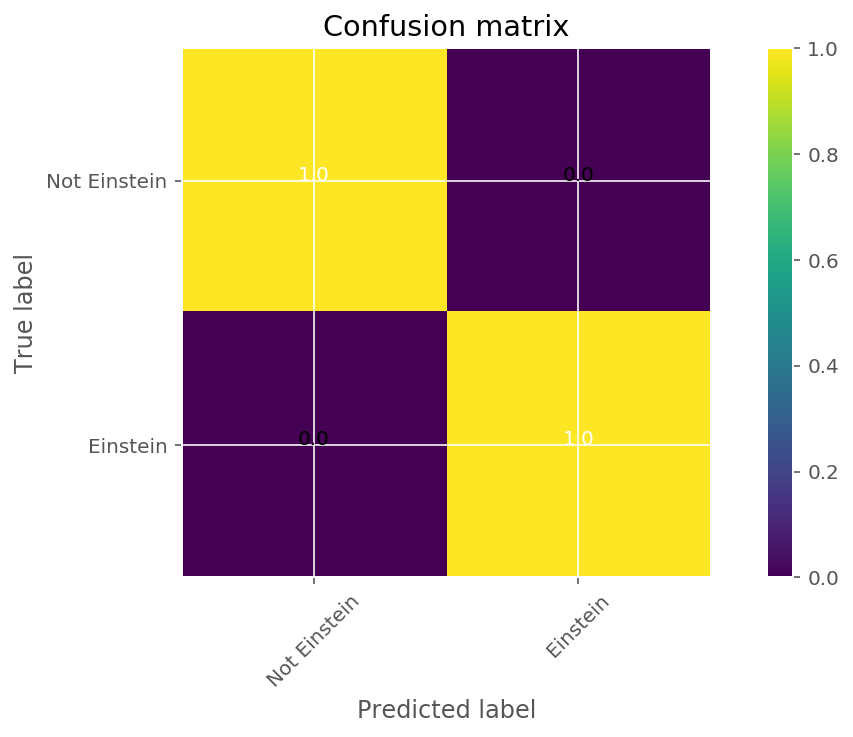

In [15]:
rfe = RandomForestClassifier(n_estimators=64, criterion='entropy', n_jobs=-1,
                             verbose=True)
rfe = rfe.fit(x_train_sampled_enc, y_train_sampled)

y_pred_rw = rfe.predict(encoder_model.predict(x_rw, verbose=False))
plot_cm(confusion_matrix(y_rw, y_pred_rw), normalize=True,
        classes=["Not Einstein", "Einstein"])
pl.show()